# Corrupted labels are a useful way to measure a networks generalization potential
- https://arxiv.org/pdf/1611.03530.pdf

In [1]:
import os
import json
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from src.data_loader import Shifted_Data_Loader,upsample_dataset
from src.plot import orig_vs_transformed as plot_ovt
from src.plot import enc_dec_samples
from src.models import GResNet,EDense,EResNet,EConvNet
from src.config import get_config
from src.trainer import Trainer
from src.utils import prepare_dirs_and_logger
from keras.datasets import fashion_mnist,mnist
from keras.layers import Dense
from keras.models import Model
from keras.utils import to_categorical
from keras.optimizers import adadelta

Using TensorFlow backend.


In [2]:
config,_ = get_config()
# Boilerplate
setattr(config, 'proj_root', '/home/elijahc/projects/vae')
setattr(config, 'log_dir', '/home/elijahc/projects/vae/logs')
setattr(config, 'dev_mode',False)
setattr(config, 'seed', 7)
setattr(config, 'project','vae')
setattr(config, 'ecc_max',4.8/8.0)
setattr(config, 'bg_noise',0.2)
setattr(config, 'contrast_level',0.3)
# setattr(config, 'rot_max',90.0/360.0)
setattr(config, 'rot_max',0)

# Training Params
setattr(config, 'batch_size', 512)
setattr(config, 'dataset', 'fashion_mnist')
setattr(config, 'epochs',27)
setattr(config, 'monitor', None)
# setattr(config, 'lr', 10)
# setattr(config, 'min_delta', 0.25)
# setattr(config, 'monitor', 'val_loss')
setattr(config, 'optimizer', 'nadam')
setattr(config, 'label_corruption',0.0)

In [3]:
# Architecture Params
setattr(config, 'enc_blocks', [128,256,512])
setattr(config, 'enc_arch', 'convnet-4')
setattr(config, 'dec_blocks', [4,2,1])
setattr(config, 'z_dim', 35)
setattr(config, 'y_dim', 35)

In [4]:
if config.ecc_max == 0.:
    translation_amt = None
else:
    translation_amt = config.ecc_max

if config.rot_max == 0.:
    rot_max = None
else:
    rot_max = config.rot_max
    
if config.bg_noise == 0.:
    bg_noise = None
else:
    bg_noise = config.bg_noise

# Loss Weights
setattr(config, 'xcov', 0)
setattr(config, 'recon', 3)
setattr(config, 'xent', 15)
# setattr(config,'model_dir','/home/elijahc/projects/vae/models/2019-06-07/recon_{}_xent_{}/label_corruption_{}'.format(config.recon,config.xent,config.label_corruption))
setattr(config,'model_dir','/home/elijahc/projects/vae/models/2019-06-05/xent_{}_recon_{}_{}/bg_noise_{}'.format(config.xent,config.recon,config.enc_arch,config.bg_noise))

In [5]:
np.random.seed(7)
if not config.dev_mode:
    print('setting up...')
    prepare_dirs_and_logger(config)
    
vars(config)


setting up...
/home/elijahc/projects/vae/models/2019-06-05/xent_15_recon_3_convnet-4/bg_noise_0.2  does not exist...
creating...
/home/elijahc/projects/vae/logs/0730_020842_fashion_mnist  does not exist...
creating...


{'batch_size': 512,
 'bg_noise': 0.2,
 'contrast_level': 0.3,
 'dataset': 'fashion_mnist',
 'dec_blocks': [4, 2, 1],
 'dev_mode': False,
 'ecc_max': 0.6,
 'enc_arch': 'convnet-4',
 'enc_blocks': [128, 256, 512],
 'enc_layers': [500, 500],
 'epochs': 27,
 'label_corruption': 0.0,
 'log_dir': '/home/elijahc/projects/vae/logs',
 'log_level': 'INFO',
 'model_dir': '/home/elijahc/projects/vae/models/2019-06-05/xent_15_recon_3_convnet-4/bg_noise_0.2',
 'model_name': '0730_020842_fashion_mnist',
 'monitor': None,
 'optimizer': 'nadam',
 'proj_root': '/home/elijahc/projects/vae',
 'project': 'vae',
 'recon': 3,
 'rot_max': 0,
 'run_dir': '/home/elijahc/projects/vae/logs/0730_020842_fashion_mnist',
 'seed': 7,
 'xcov': 0,
 'xent': 15,
 'y_dim': 35,
 'z_dim': 35}

In [6]:
oversample_factor=3
DL = Shifted_Data_Loader(dataset=config.dataset,flatten=False,num_train=60000*oversample_factor,
                         translation=translation_amt,
                         rotation=rot_max,
                         contrast_level=config.contrast_level,
                         noise_mode='uniform',
                         noise_kws={
                             'amount':1,
                             'width':config.bg_noise,
                         },
                         bg_only=False,
                        )

input_shape:  (56, 56, 1)
dataset:  fashion_mnist
scale:  2
tx_max:  0.6
rot_max:  None
contrast_level:  0.3
noise_mode:  uniform
  width: 0.2
  amount: 1
creating noise uniform({'width': 0.2, 'amount': 1})...
sx_train:  (180000, 56, 56, 1)


train images:   2%|▏         | 3110/180000 [00:00<00:05, 31088.91it/s]

transforming: 


test_images:  63%|██████▎   | 6306/10000 [00:00<00:00, 31183.52it/s]

making testing data...


test_images: 100%|██████████| 10000/10000 [00:00<00:00, 31416.55it/s]


Rescaling contrast to 0.3
adding noise to training set
adding noise to test set


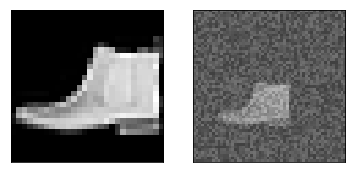

In [7]:
pt,idx = plot_ovt(DL,cmap='gray')

In [8]:
# plt.imshow(DL.fg_train[50].reshape(56,56),cmap='gray',vmin=0,vmax=1)

In [9]:
G_builder = GResNet(y_dim=config.y_dim,z_dim=config.z_dim,dec_blocks=config.dec_blocks,flatten_out=False)
E_builder = EConvNet(blocks=config.enc_blocks,z_dim=config.z_dim,output_size=512)
trainer = Trainer(config,DL,E_builder,G_builder,)
# setattr(trainer.config,'model_dir','/home/elijahc/projects/vae/models/2019-01-22/')

building encoder...
building decoder/generator...


In [10]:
trainer.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, 56, 56, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 128)  1280        input_image[0][0]                
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 256)  295168      conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 7, 7, 512)    1180160     conv2d_2[0][0]                   
__________________________________________________________________________________________________
batch_norm

In [11]:
# trainer.build_model()
trainer.compile_model()
# trainer.G.summary()

In [12]:
DL.sx_test.shape

(10000, 56, 56, 1)

In [13]:
val_pct = 0.05
val_idxs = np.random.choice(np.arange(10000),int(val_pct*60000),replace=False)
validation_set = (DL.sx_test[val_idxs],
                  {'class':DL.y_test_oh[val_idxs],
                   'G':DL.fg_test[val_idxs]}
                 )

In [14]:
if config.label_corruption >= 0.1:
    # Load corrupted Labels
    y_tr_corr = np.load('../data/fashion_mnist_corrupted_labels/y_train_{}.npy'.format(config.label_corruption))
    y_tr_corr = upsample_dataset(y_tr_corr,180000-60000)
    y_corr_idxs = np.load('../data/fashion_mnist_corrupted_labels/corrupted_idxs_{}.npy'.format(config.label_corruption))
    y_corr_idxs = np.concatenate([y_corr_idxs,(y_corr_idxs+60000),y_corr_idxs+120000],axis=0)
    y_corrupted_oh = to_categorical(y_tr_corr,num_classes=10)
    y = y_corrupted_oh
    DL.gen_corrupted_shift_image(y_corr_idxs,y_tr_corr)
else:
    y = DL.y_train_oh

In [15]:
trainer.go(x=DL.sx_train,
           y={
               'class':y,
#                'D_real':RF,
               'G':DL.fg_train},
#            validation_split=0.05,
           shuffle=True,
           validation_data=validation_set,
           verbose=0)

Epoch        G_loss      val_G_loss  class_acc   val_class_acc
0:           24.7535     9.1445      0.3379      0.372       
1:           6.7785      5.1533      0.6404      0.646       
2:           5.5759      6.8769      0.7044      0.6667      
3:           4.7691      5.1137      0.734       0.7223      
4:           4.1913      4.9052      0.7577      0.7103      
5:           3.7792      4.2919      0.7754      0.7307      
6:           3.4051      2.9234      0.7867      0.7197      
7:           3.1396      3.2651      0.7963      0.7283      
8:           2.9132      3.2697      0.8031      0.7837      
9:           2.7366      2.7426      0.8107      0.7307      
10:          2.6111      2.4372      0.8161      0.7903      
11:          3.005       3.0864      0.7731      0.7557      
12:          2.4556      2.3446      0.8109      0.7803      
13:          2.3192      35.0282     0.8243      0.095       
14:          4.3605      3.2676      0.7015      0.705       
15:    

In [16]:
DL.sx_train.shape

(180000, 56, 56, 1)

In [17]:
hist_df = pd.DataFrame.from_records(trainer.model.history.history)
hist_df.head()

,G_loss,G_mse,class_acc,class_loss,loss,val_G_loss,val_G_mse,val_class_acc,val_class_loss,val_loss
0,24.753528,0.007893,0.337939,1.790167,101.122824,9.144548,0.002916,0.372000,1.642970,52.087865
1,6.778500,0.002162,0.640439,0.975418,34.976404,5.153291,0.001643,0.646000,0.991167,30.336971
2,5.575875,0.001778,0.704383,0.811697,28.912634,6.876888,0.002193,0.666667,0.990785,35.501961
3,4.769082,0.001521,0.733983,0.727469,25.228774,5.113738,0.001631,0.722333,0.744860,26.523571
4,4.191299,0.001337,0.757683,0.663998,22.543295,4.905161,0.001564,0.710333,0.831002,27.189910


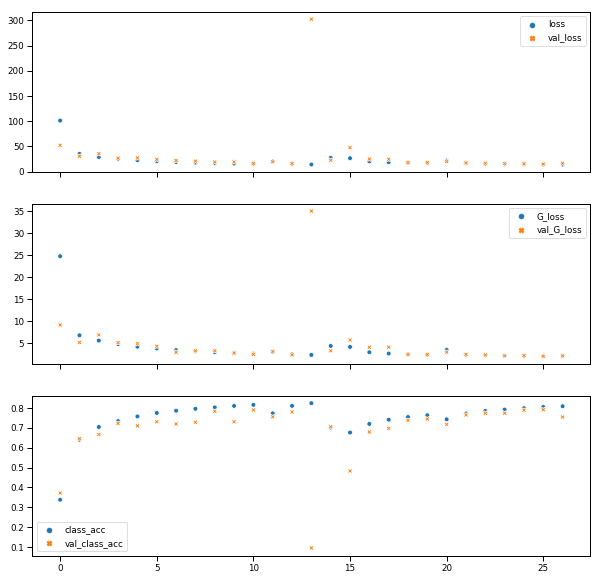

In [18]:
sns.set_context('paper')
metrics = ['loss','G_loss','class_acc']
fig,axs = plt.subplots(nrows=len(metrics),sharex=True,figsize=(10,10))
for metric_name,ax in zip(metrics,axs):
    sns.scatterplot(data=hist_df[[metric_name,'val_'+metric_name]],ax=ax)

In [19]:
hist_df['generalization_error'] = hist_df.val_loss - hist_df.loss
hist_df['G_generalization_error'] = hist_df.val_G_loss - hist_df.G_loss
hist_df['class_generalization_error'] = hist_df.val_class_loss - hist_df.class_loss

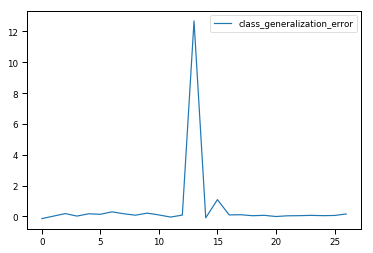

In [20]:
sns.lineplot(data=hist_df[['class_generalization_error']])
# plt.yscale('log')

In [21]:
import datetime as dt
def clean_config(config,keys=['dev_mode','log_dir','log_level','proj_root']):
    c = vars(config)
    for k in keys:
        if k in c.keys():
            del c[k]
    
    c['uploaded_by']='elijahc'
    c['last_updated']= str(dt.datetime.now())
    return c

In [22]:
run_meta = clean_config(config)
run_meta['project']='vae'
# run_meta['ecc_max']=0.8
run_meta

{'batch_size': 512,
 'bg_noise': 0.2,
 'contrast_level': 0.3,
 'dataset': 'fashion_mnist',
 'dec_blocks': [4, 2, 1],
 'ecc_max': 0.6,
 'enc_arch': 'convnet-4',
 'enc_blocks': [128, 256, 512],
 'enc_layers': [500, 500],
 'epochs': 27,
 'label_corruption': 0.0,
 'last_updated': '2019-07-30 02:31:07.463665',
 'model_dir': '/home/elijahc/projects/vae/models/2019-06-05/xent_15_recon_3_convnet-4/bg_noise_0.2',
 'model_name': '0730_020842_fashion_mnist',
 'monitor': None,
 'optimizer': 'nadam',
 'project': 'vae',
 'recon': 3,
 'rot_max': 0,
 'run_dir': '/home/elijahc/projects/vae/logs/0730_020842_fashion_mnist',
 'seed': 7,
 'uploaded_by': 'elijahc',
 'xcov': 0,
 'xent': 15,
 'y_dim': 35,
 'z_dim': 35}

In [23]:
trainer.config = config

In [24]:
trainer.save_model()
run_conf = clean_config(config)

with open(os.path.join(run_conf['model_dir'],'config.json'), 'w') as fp:
    json.dump(run_conf, fp)

hist_df.to_parquet(os.path.join(run_conf['model_dir'],'train_history.parquet'))

In [25]:
generator = trainer.G

In [26]:
trainer.E.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, 56, 56, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 128)  1280        input_image[0][0]                
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 256)  295168      conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 7, 7, 512)    1180160     conv2d_2[0][0]                   
__________________________________________________________________________________________________
batch_norm

In [27]:
z_encoder = Model(trainer.input,trainer.z_lat)
y_encoder = Model(trainer.input,trainer.y_lat)
classifier = Model(trainer.input,trainer.y_class)

l3_encoder = Model(trainer.input,trainer.model.get_layer(name='dense_1').output)
l1_encoder = Model(trainer.input,trainer.model.get_layer(name='conv2d_1').output)
# l2_encoder = Model(trainer.input,trainer.model.get_layer(name='block_2_Add_2').output)
# l2_encoder = Model(trainer.input,trainer.model.get_layer(name='block_4_Add_1').output)
l2_encoder = Model(trainer.input,trainer.model.get_layer(name='conv2d_3').output)

In [28]:
mod = trainer.model

In [29]:
# mod.summary()

In [30]:
def get_weight_grad(model, inputs, outputs):
    """ Gets gradient of model for given inputs and outputs for all weights"""
    grads = model.optimizer.get_gradients(model.total_loss, model.trainable_weights)
    symb_inputs = (model._feed_inputs + model._feed_targets + model._feed_sample_weights)
    f = K.function(symb_inputs, grads)
    x, y, sample_weight = model._standardize_user_data(inputs, outputs)
    output_grad = f(x + y + sample_weight)
    return output_grad

In [31]:
classifier.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
res = classifier.evaluate(DL.sx_test,DL.y_test_oh,batch_size=config.batch_size)
ts_error = 1-res[1]
print(res[1])
df = pd.DataFrame.from_records({'test_acc':[res[1]],
                                'label_corruption':[config.label_corruption],
                                'recon':[config.recon],
                                'xent':[config.xent],
                                'ecc_max':[config.ecc_max],
                                'xcov': [config.xcov]})
df.to_json(os.path.join(config.model_dir,'performance.json'))

10000/10000 [==============================] - 1s 102us/step
0.7516000007629394


In [32]:
out_s = l1_encoder.output_shape
type(out_s)

tuple

In [33]:
l1_enc = l1_encoder.predict(DL.sx_test,batch_size=config.batch_size).reshape(10000,np.prod(l1_encoder.output_shape[1:]))
l2_enc = l2_encoder.predict(DL.sx_test,batch_size=config.batch_size).reshape(10000,np.prod(l2_encoder.output_shape[1:]))
l3_enc = l3_encoder.predict(DL.sx_test,batch_size=config.batch_size).reshape(10000,np.prod(l3_encoder.output_shape[1:]))

z_enc = z_encoder.predict(DL.sx_test,batch_size=config.batch_size)
# y_lat = y_lat_encoder.predict(DL.sx_test,batch_size=config.batch_size)
y_enc = y_encoder.predict(DL.sx_test,batch_size=config.batch_size)

In [34]:
l1_enc.shape

(10000, 100352)

In [35]:
import xarray
import hashlib
import random
def raw_to_xr(encodings,l_2_depth,stimulus_set):
    obj_names = [
        "T-shirt",
        "Trouser",
        "Pullover",
        "Dress",
        "Coat",
        "Sandal",
        "Dress Shirt",
        "Sneaker",
        "Bag",
        "Ankle boot",
    ]
    all_das = []
    for layer,activations in encodings.items():
        neuroid_n = activations.shape[1]
        n_idx = pd.MultiIndex.from_arrays([
            pd.Series(['{}_{}'.format(layer,i) for i in np.arange(neuroid_n)],name='neuroid_id'),
            pd.Series([l_2_depth[layer]]*neuroid_n,name='layer'),
            pd.Series([layer]*neuroid_n,name='region')
        ])
        p_idx = pd.MultiIndex.from_arrays([
            stimulus_set.image_id,
            stimulus_set.dx,
            stimulus_set.dy,
            stimulus_set.rxy,
            stimulus_set.numeric_label.astype('int8'),
            pd.Series([obj_names[i] for i in stimulus_set.numeric_label],name='object_name'),
            pd.Series(stimulus_set.dx.values/28, name='tx'),
            pd.Series(stimulus_set.dy.values/28, name='ty'),
            pd.Series([1.0]*len(stimulus_set),name='s'),
        ])
        da = xarray.DataArray(activations.astype('float32'),
                         coords={'presentation':p_idx,'neuroid':n_idx},
                         dims=['presentation','neuroid'])
        all_das.append(da)
        
    return xarray.concat(all_das,dim='neuroid')

In [36]:
encodings = {
    'pixel':DL.sx_test.reshape(10000,np.prod(DL.sx_test.shape[1:])),
    'dense_1':l1_enc,
    'dense_2':l2_enc,
    'dense_3':l3_enc,
    'y_lat':y_enc,
    'z_lat':z_enc
}
depths = {
    'pixel':0,
    'dense_1':1,
    'dense_2':2,
    'dense_3':3,
    'y_lat':4,
    'z_lat':4
}
slug = [(dx,dy,float(lab),float(random.randrange(20))) for dx,dy,rxy,lab in zip(DL.dx[1],DL.dy[1],DL.dtheta[1],DL.y_test)]
image_id = [hashlib.md5(json.dumps(list(p),sort_keys=True).encode('utf-8')).digest().hex() for p in slug]
stim_set = pd.DataFrame({'dx':DL.dx[1]-14,'dy':DL.dy[1]-14,'numeric_label':DL.y_test,'rxy':DL.dtheta[1],'image_id':image_id})

In [37]:
out = raw_to_xr(encodings,depths,stim_set)

In [38]:
out = raw_to_xr(encodings,depths,stim_set)
from collections import OrderedDict
def save_assembly(da,run_dir,fname,**kwargs):
    da = da.reset_index(da.coords.dims)
    da.attrs = OrderedDict()
    with open(os.path.join(run_dir,fname), 'wb') as fp:
        da.to_netcdf(fp,**kwargs)
        
    
save_assembly(out,run_dir=config.model_dir,fname='dataset.nc',
    format='NETCDF3_64BIT',
#         engine=
#         encoding=enc,
)

In [39]:
# z_enc_tr = z_encoder.predict(DL.sx_train,batch_size=config.batch_size)
# y_lat = y_lat_encoder.predict(DL.sx_test,batch_size=config.batch_size)
# y_enc_tr = y_encoder.predict(DL.sx_train,batch_size=config.batch_size)

In [40]:
np.save(os.path.join(config.model_dir,'z_enc'),z_enc)
np.save(os.path.join(config.model_dir,'l1_enc'),l1_enc)
np.save(os.path.join(config.model_dir,'l2_enc'),l2_enc)
np.save(os.path.join(config.model_dir,'y_enc'),y_enc)

In [41]:
y_enc.shape

(10000, 35)

In [42]:
_lat_vec = np.concatenate([y_enc,z_enc],axis=1)
_lat_vec.shape

(10000, 70)

In [43]:
z_enc_mu = np.mean(z_enc,axis=0)
z_enc_cov = np.cov(z_enc,rowvar=False)

In [44]:
np.random.multivariate_normal(z_enc_mu,z_enc_cov,size=50).shape

(50, 35)

In [45]:
regen = generator.predict(_lat_vec,batch_size=config.batch_size)

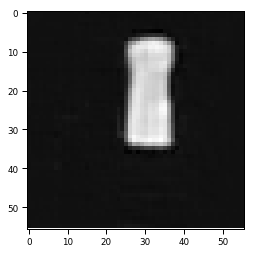

In [46]:
rand_im = np.random.randint(0,10000)
plt.imshow(regen[rand_im].reshape(56,56),cmap='gray')

In [47]:
_lat_vec[rand_im]

array([ 1.6221056 , -1.9631258 ,  2.7289202 , -7.8059607 ,  1.2491763 ,
       -2.1818867 ,  0.08738335,  2.2012265 , -2.734463  , -1.8348576 ,
        2.3160179 ,  1.3455125 ,  0.17850064,  0.25418687,  1.2759738 ,
       -1.7136252 ,  1.7360951 , -0.55480057, -2.0346394 ,  7.4564395 ,
       -2.5477207 ,  1.2445788 , -1.0242865 ,  3.2110698 ,  2.8719413 ,
       -1.1086881 ,  1.470255  ,  0.04733519, -0.8561893 , -0.5101032 ,
        2.8391697 , -0.28143707, -0.8134153 , -5.699847  ,  5.419055  ,
        2.47194   , -0.04744054,  0.91756976,  4.0554714 , -0.19617349,
        0.6017091 ,  0.89592576, -1.4483541 , -2.0175085 , -2.738494  ,
       -1.0133467 ,  0.44318613,  1.9370706 ,  1.5724769 , -0.5258735 ,
       -3.533811  ,  0.5138601 ,  3.3136818 ,  0.2808326 , -1.7374597 ,
       -0.19286732, -3.7203708 , -3.6416628 , -1.2985281 , -1.5392348 ,
        0.03250602,  0.189795  ,  1.9087781 , -2.3172996 , -3.271667  ,
        0.6330906 , -0.0743917 , -4.0933285 , -1.4478383 ,  0.08

In [48]:
DL2 = Shifted_Data_Loader(dataset=config.dataset,flatten=False,
                          rotation=None,
                          translation=translation_amt,
                          bg_noise=bg_noise,
                          bg_only=False,
                        )

input_shape:  (56, 56, 1)
dataset:  fashion_mnist
scale:  2
tx_max:  0.6
rot_max:  None
contrast_level:  1
noise_mode:  None


train images:   0%|          | 0/60000 [00:00<?, ?it/s]

sx_train:  (60000, 56, 56, 1)
transforming: 


test_images:  29%|██▉       | 2893/10000 [00:00<00:00, 28926.92it/s]

making testing data...


test_images: 100%|██████████| 10000/10000 [00:00<00:00, 28826.77it/s]


In [49]:
# enc_dec_samples(DL.x_train,DL.sx_train,z_enc_tr,y_enc_tr,generator)

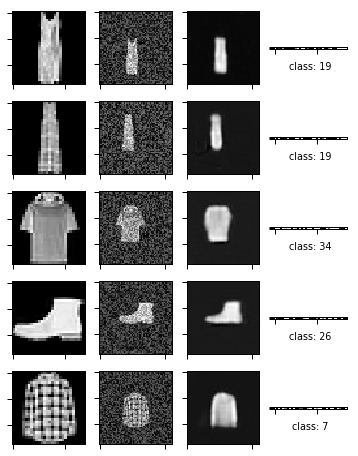

In [50]:
enc_dec_samples(DL.x_test,DL.sx_test,z_enc,y_enc,generator)

In [51]:
z_enc2 = z_encoder.predict(DL2.sx_test,batch_size=config.batch_size)
y_lat2 = y_encoder.predict(DL2.sx_test,batch_size=config.batch_size)
_lat_vec2 = np.concatenate([y_lat2,z_enc2],axis=1)
regen2 = generator.predict(_lat_vec2,batch_size=config.batch_size)

In [52]:
from src.plot import remove_axes,remove_labels
from src.utils import gen_trajectory

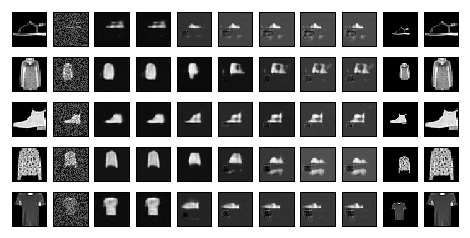

In [53]:
examples = 5
rand_im = np.random.randint(0,10000,size=examples)
fix,axs = plt.subplots(examples,11,figsize=(8,4))
_lat_s = []
regen_s = []
out = gen_trajectory(z_enc[rand_im],z_enc2[rand_im],delta=.25)
out_y = gen_trajectory(y_enc[rand_im],y_lat2[rand_im],delta=.25)

for z,y in zip(out,out_y):
    _lat = np.concatenate([y,z],axis=1)
    _lat_s.append(_lat)
    regen_s.append(generator.predict(_lat,batch_size=config.batch_size))

i=0
for axr,idx in zip(axs,rand_im):
    axr[0].imshow(DL.x_test[idx].reshape(28,28),cmap='gray')
    axr[1].imshow(DL.sx_test[idx].reshape(56,56),cmap='gray')
    axr[2].imshow(regen[idx].reshape(56,56),cmap='gray')
    for j,a in enumerate(axr[3:-3]):
        a.imshow(regen_s[j][i,:].reshape(56,56),cmap='gray')
#         a.imshow(s.reshape(56,56),cmap='gray')
    axr[-3].imshow(regen2[idx].reshape(56,56),cmap='gray')
    axr[-2].imshow(DL2.sx_test[idx].reshape(56,56),cmap='gray')
    axr[-1].imshow(DL2.x_test[idx].reshape(28,28),cmap='gray')
    for a in axr:
        remove_axes(a)
        remove_labels(a)
    i+=1
# plt.imshow(regen[rand_im].reshape(56,56),cmap='gray')

In [54]:
# fix.savefig('../../updates/2019-02-05/assets/img/translocate_{}.png'.format(translation_amt))

In [55]:
fdjsakl;fdsa

NameError: name 'fdjsakl' is not defined

In [ ]:
dxs = DL.dx[1]-14
dys = DL.dy[1]-14

In [ ]:
from sklearn.preprocessing import MinMaxScaler

feat_range = (0,30)
z_enc_scaled = [MinMaxScaler(feat_range).fit_transform(z_enc[:,i].reshape(-1,1)).tolist() for i in np.arange(25)]
z_enc_scaled = np.squeeze(np.array(z_enc_scaled,dtype=int))

In [ ]:
l2_enc_scaled = [MinMaxScaler(feat_range).fit_transform(l2_enc[:,i].reshape(-1,1)).tolist() for i in np.arange(2000)]
l2_enc_scaled = np.squeeze(np.array(l2_enc_scaled,dtype=int))

In [ ]:
l2_enc_scaled.shape

In [ ]:
from collections import Counter
import dit
from dit import Distribution

def mutual_information(X,Y):
    XY_c = Counter(zip(X,Y))
    XY_pmf = {k:v/float(sum(XY_c.values())) for k,v in XY_c.items()}
    XY_jdist = Distribution(XY_pmf)
        
    return dit.shannon.mutual_information(XY_jdist,[0],[1])

In [ ]:
z_dx_I = [mutual_information(z_enc_scaled[i],dxs.astype(int)+14) for i in np.arange(25)]
l2_dx_I = [mutual_information(l2_enc_scaled[i],dxs.astype(int)+14) for i in np.arange(2000)]

In [ ]:
z_dy_I = [mutual_information(z_enc_scaled[i],dys.astype(int)+14) for i in np.arange(25)]
l2_dy_I = [mutual_information(l2_enc_scaled[i],dys.astype(int)+14) for i in np.arange(2000)]

In [ ]:
z_class_I = [mutual_information(z_enc_scaled[i],DL.y_test) for i in np.arange(25)]
l2_class_I = [mutual_information(l2_enc_scaled[i],DL.y_test) for i in np.arange(2000)]

In [ ]:
z_I_df = pd.DataFrame.from_records({'class':z_class_I,'dy':z_dy_I,'dx':z_dx_I})
z_I_df['class'] = z_I_df['class'].values.round(decimals=1)

In [ ]:
l2_I_df = pd.DataFrame.from_records({
    'class':l2_class_I,
    'dy':l2_dy_I,
    'dx':l2_dx_I})
l2_I_df['class'] = l2_I_df['class'].values.round(decimals=1)

In [ ]:
l2_I_df.head()

In [ ]:
plt.hist(l2_I_df.dx)

In [ ]:
plt.hist(z_I_df.dx)

In [ ]:
config.translation_amt = translation_amt
config.translation_amt

In [ ]:
dir_path = '../data/xcov_importance/dist_{}/'.format(translation_amt)

z_I_df.to_pickle('../data/xcov_importance/dist_{}/z_mutual_info.pk'.format(translation_amt))
np.save('../data/xcov_importance/dist_{}/dxs'.format(translation_amt), DL.dx[1]-14)
np.save('../data/xcov_importance/dist_{}/dys'.format(translation_amt), DL.dy[1]-14)
np.save('../data/xcov_importance/dist_{}/z_enc'.format(translation_amt), z_enc)

hist_df.to_pickle(os.path.join(dir_path,'training_hist.df'))

with open(os.path.join(dir_path,'config.json'), 'w') as fp:
        json.dump(vars(config), fp)

In [ ]:
def filter_by_weight(wts,thresh=0.01):
    idxs = np.abs(wts)>thresh
    return idxs

In [ ]:
dx_max = np.argmax(z_I_df.dx.values)
dy_max = np.argmax(z_I_df.dy.values)

In [ ]:
t = 0.05
dx_filt = filter_by_weight(z_w_k[:,dx_max],thresh=t)
dy_filt = filter_by_weight(z_w_k[:,dy_max],thresh=t)
union = np.union1d(np.where(dx_filt==True),np.where(dy_filt==True))
intersect = np.intersect1d(np.where(dx_filt==True),np.where(dy_filt==True))
# filt = np.array([False]*2000)
# filt[union] = True

sns.set_context('talk')
fig,axs = plt.subplots(1,2,figsize=(6*2,5))

filt = dy_filt
print('num: ',len(union))
print('intersect_frac: ',float(len(intersect))/len(union))
print('mean dx_I: ',l2_I_df.dx[filt].mean())
print('mean dy_I: ',l2_I_df.dy[filt].mean())
points = axs[0].scatter(x=l2_I_df['dx'],y=l2_I_df['dy'],
                        c=l2_I_df['class'],cmap='viridis',vmin=0,vmax=0.4,s=z_I_df['class']*100
                       )
plt.colorbar(points)
points = axs[1].scatter(x=z_I_df['dx'],y=z_I_df['dy'],c=z_I_df['class'],cmap='viridis',s=z_I_df['class']*100,vmin=0,vmax=0.4)
# plt.colorbar(points)
axs[0].set_ylim(0,0.9)
axs[0].set_xlim(0,0.9)
axs[1].set_ylim(0,0.9)
axs[1].set_xlim(0,0.9)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(z_dx_I,z_dy_I)
# ax.set_ylim(0,0.8)
# ax.set_xlim(0,0.8)

In [ ]:
plt.scatter(np.arange(25),sorted(z_class_I,reverse=True))
# plt.scatter(np.arange(25),z_dx_I)
# plt.scatter(np.arange(25),z_dy_I)

In [ ]:
from src.metrics import var_expl,norm_var_expl
from collections import Counter

dtheta = DL.dtheta[1]
fve_dx = norm_var_expl(features=z_enc,cond=dxs,bins=21)
fve_dy = norm_var_expl(features=z_enc,cond=dys,bins=21)
fve_class = norm_var_expl(features=z_enc, cond=DL.y_test, bins=21)
# fve_dt = norm_var_expl(features=z_enc,cond=dtheta,bins=21)

In [ ]:
# fve_dx_norm = (dxs.var()-fve_dx)/dxs.var()
# fve_dy_norm = (dys.var()-fve_dy)/dys.var()
# fve_dth_norm = (dtheta.var()-fve_dt)/dtheta.var()
fve_dx_norm = fve_dx
fve_dy_norm = fve_dy

In [ ]:
import seaborn as sns
sns.set_context('talk')

In [ ]:
fve_dx_norm.shape
# np.save(os.path.join(config.model_dir,'fve_dx_norm'),fve_dx_norm)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
plt.scatter(fve_dx_norm.mean(axis=0),fve_dy_norm.mean(axis=0))
plt.xlabel('fve_dx')
plt.ylabel('fve_dy')
plt.tight_layout()
# plt.savefig(os.path.join(config.model_dir,'fve_dx.png'))
# plt.ylim(-0.125,0.25)
xdim = np.argmax(fve_dx_norm.mean(axis=0))

In [ ]:
fve_dy_norm.mean(axis=0)
# np.save(os.path.join(config.model_dir,'fve_dy_norm'),fve_dy_norm)

In [ ]:
plt.scatter(np.arange(config.z_dim),fve_dy_norm.mean(axis=0))
plt.xlabel('Z_n')
plt.ylabel('fve_dy')
plt.tight_layout()
# plt.savefig(os.path.join(config.model_dir,'fve_dy.png'))
# plt.ylim(-0.125,0.25)
ydim = np.argmax(fve_dy_norm.mean(axis=0))

In [ ]:
plt.scatter(np.arange(config.z_dim),fve_class.mean(axis=0))
plt.xlabel('Z_n')
plt.ylabel('fve_class')
# plt.ylim(0.0,0.5)
np.argmax(fve_class.mean(axis=0))

In [ ]:
from src.plot import Z_color_scatter
Z_color_scatter(z_enc,[xdim,ydim],dxs)

In [ ]:
Z_color_scatter(z_enc,[xdim,ydim],dys)

In [ ]:
Z_color_scatter(z_enc,[7,18],dtheta)

In [ ]:
from plt.